In [7]:
# The goal is to dig deep into encoder and see how it extracts answer from a context

# Load the model first
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [10]:
# Check how the tokenizer encodes questions and answers
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
print(inputs)

# Printing the input will show us familiar input_ids and attention mask. We will also see token_type_ids where 0 indicates question and 1 indicates answer.
# Lets also decode and see how texts are formatted. Notice the [CLS] and [SEP] tokens. Its pretty straightforward.
print(tokenizer.decode(inputs["input_ids"][0]))

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}
[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [11]:
# QA as just like token classification. In chapter 2, we extracted the last hidden state. This time, we do a similar thing but extract the output directly for inspection.
# The output is what we get from the QA head, which is a linear layer that takes the hidden state from the encoder as input and computes the logits for the state and end spans.
import torch
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [13]:
# Now how do we convert these logits to answer span? Lets inspect them first.
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


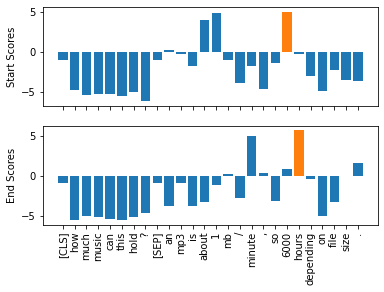

In [15]:
# As we can see, each input token is also associated with two logits: start and end. Higher value means they are a better candidate. Lets visualize them to get a better idea.
#hide_input
#id qa-scores
#caption Predicted logits for the start and end tokens; the token with the highest score is colored in orange

# The idea for this visualisation comes from https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [16]:
# Since maximum gives us the logits, we can apply argmax to extract the span. In practice, taking a single argmax is not enough because
# we can also mistakenly select the question itself! The real pipeline computes more heuristics to produce the answer. For example,
# being-in-scope, start before end etc.
import torch 

start_idx = torch.argmax(start_logits)  
end_idx = torch.argmax(end_logits) + 1  
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [17]:
# Of course all these is wrapped in a convenient function in Transformer library.
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/home/tanvir/work/huggingface-starter/.env/lib/python3.10/site-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516157388687134,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082938253879547,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253529995679855,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [18]:
# The pipeline function also returns as a score for each answer. This is achieved by, surprise, surprise, taking a softmax over the logits.

# So we are done with disecting the QA pipeline, except, context size can bigger than what the model can handle. In that case, we use a sliding window appraoch.
# We set return_overflow_token = True to enable the window. The size of the sliding window is controlled by the max_seq_length argument, and the size of the
# stride (how many tokens to skip) is decided by stride param.

question = "How is the bass?"
context = """i have had koss headphones in the past, pro 4aa and \
qz - 99. the koss portapro is portable and has great bass response. the work \
great with my android phone and can be rolled up to be carried in my \
motorcycle jacket or computer bag without getting crunched. they are very light \
and don't feel heavy or bear down on your ears even after listening to music \
with them on all day. the sound is night and day better \
than any ear - bud could be and are almost as good as the pro 4aa. they are \
open air headphones so you cannot match the bass to the sealed types, but it \
comes close. for $ 32, you cannot go wrong."""

tokenized_example = tokenizer(question, context, return_overflowing_tokens = True, max_length = 100, stride = 25)

# Lets print how many token each window has
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

# We can also print to check the overlapping in sliding windows
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Window #0 has 100 tokens
Window #1 has 85 tokens
[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be rolled up to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night [SEP] 

[CLS] how is the bass? [SEP]'t feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are open air headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 

